# Lab 4

In [23]:
### MATPLOTLIB SETUP ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import sys
pd.set_option('display.float_format', lambda x: '%e' % x)

## Amit's library with some utility functions for reading and processing scope data; reproduced below
sys.path.append("../../")
from lib import *

from rich.console import Console
from rich.syntax import Syntax
Console().print(Syntax.from_path("../../lib.py", line_numbers=True, theme="monokai"))

## Jupyter magic
%matplotlib
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

   1 import csv                                                                                                    
   2 import pandas as pd                                                                                           
   3 import numpy as np                                                                                            
   4                                                                                                               
   5 R = 5 # Load Resistance                                                                                       
   6 VG = 18 # Input Voltage                                                                                       
   7 Fs = 50500 # Measured frequency                                                                               
   8 Ts = 1/ Fs                                                                                                    
   9 R_SHUNT = 0.05 # from schematic                                                                               
  10                                                                                                               
  11 # read funky Rigol CSV format                                                                                 
  12 def read_rigol_csv(csv_file_name):                                                                            
  13     with open(csv_file_name) as f:                                                                            
  14         rows = list(csv.reader(f))                                                                            
  15         i = 0                                                                                                 
  16         while rows[0][i] != "":                                                                               
  17             i = i+1                                                                                           
  18         numcols = i-2                                                                                         
  19         t0 = float(rows[1][numcols])                                                                          
  20         dT = float(rows[1][numcols+1])                                                                        
  21                                                                                                               
  22     data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])                                 
  23     data['X'] = t0+data['X']*dT                                                                               
  24     return data, t0, dT                                                                                       
  25                                                                                                               
  26 def import_and_clean(name, cols, filt, filt_len=10):                                                          
  27     """                                                                                                       
  28     Import and clean some data from the Rigol scope                                                           
  29                                                                                                               
  30     @param name: name of csv file (assumed to live in `./data`)                                               
  31     @param cols: what to rename columns to                                                                    
  32     @param filt: whether to apply 10 sample rolling mean LPF                                                  
  33                                                                                                               
  34     @return pd.df - renamed/filtered dataframe                                             

Using matplotlib backend: ipympl
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prep work

### Calculating inductor design specs

We first began by calculating a minimum number of turns for our inductor, using the equation

$$N \ge \frac{L*i}{\phi_{max}}$$

where $\phi_{max} = B_{max} * A_{cmin}$

This calculation is performed in the below code cell

In [24]:
L = 2e-5 # target inductance
ipk = 6 # given in worksheet

Bmax = 0.2 # 200mT, given in worksheet
Ac = 62.6 / 10e5 # Found in core datasheet

max_flux = Bmax * Ac
min_turns = (L*ipk) / (max_flux) 
print(f"Minimum turns: {round(min_turns, 3)}")

Minimum turns: 9.585


Next, we calculated the inductance using the equation

$$L = N^2 * P$$

where

$$P = \frac{A_{eq} * \mu_0}{l_g}$$

In this case, we are approximating equivalent gap length as physical gap length, and approximating equivalent gap area by adding a band of the air gap-length around the core area. $\mu_0$ refers to the permeability of free space. We performed something of a manual search and eventually landed on a combination of 11 turns, and 12 mils of shim. This calculation is in the below code cell

In [25]:
N = 11 # user defined (# of turns)
lg = 12 # user defined (mils)
lg *= 2 # once for each half
lg *= 0.0254 / 1000 # to m

d = 8.8 / 1000 # m
d += 2 * lg # air gap band approximation
Aeq = (d/2) ** 2 * 3.14 # area of a circle
mu0 = 1.26 * 10 ** -6 # permeability of free space

P = (mu0 * Aeq)/ lg
L = N ** 2 * P
print(f"Inductance: {round(L * 1000000, 3)} uH")

Inductance: 19.708 uH


Lastly, we wanted to check that we were respecting the peak flux density in the ferrite core. We used the following inequality from the worksheet to do so:

$$\frac{2W}{\phi^2_{max}} \le R_e \le \frac{F^2_{max}}{2W}$$

where W is represents magnetic work $W = \frac{1}{2} * L * i^2$, $\phi_{max}$ is the max flux, given by the max flux density (200mT that we are trying to verify) multiplied by the effective core area, and $F_{max}$ is the max magnetomotive force given by $F_{max} = J_{max} * A_w * K_f$ (maximal current density * winding area * fill factor). This calculation is performed in the code cell below, which shows the inequality to be true, meaning that we are within the magnetic bounds of the core.

In [26]:
Rg = 1/P

W = 1/2 * L * ipk**2
LHS = (2*W)/(max_flux ** 2)

Jmax = 10 * 10e5 # given in lab worksheet
Aw = ((9 - (11.5/2)) * 14.3) / 10e5 # calculated from bobbin and core drawings
Kf = 0.2 # estimated
Fmax = Jmax * Aw * Kf
RHS = (Fmax**2)/(2*W)
print(f"lower bound: {LHS} < reluctance: {Rg} < upper bound: {RHS}: inequality is {LHS < Rg < RHS}")

lower bound: 4526270.957954545 < reluctance: 6139580.027003574 < upper bound: 12177260.079947857: inequality is True


At this point, we proceeded on to assemble our inductor by winding 11 turns of 20 AWG wire (so that they could all fit in one layer), inserting the ferrite core, separating the two halves with 12 mils of shim from the teflon paper, and placing the retaining clip to hold it all together. Olin's LCR meter measured our inductance at 19.3 uH, which was about 0.4 uH below our predicted value. For this prelab, Jun and I collaborated together on the inductor calculations and winding.

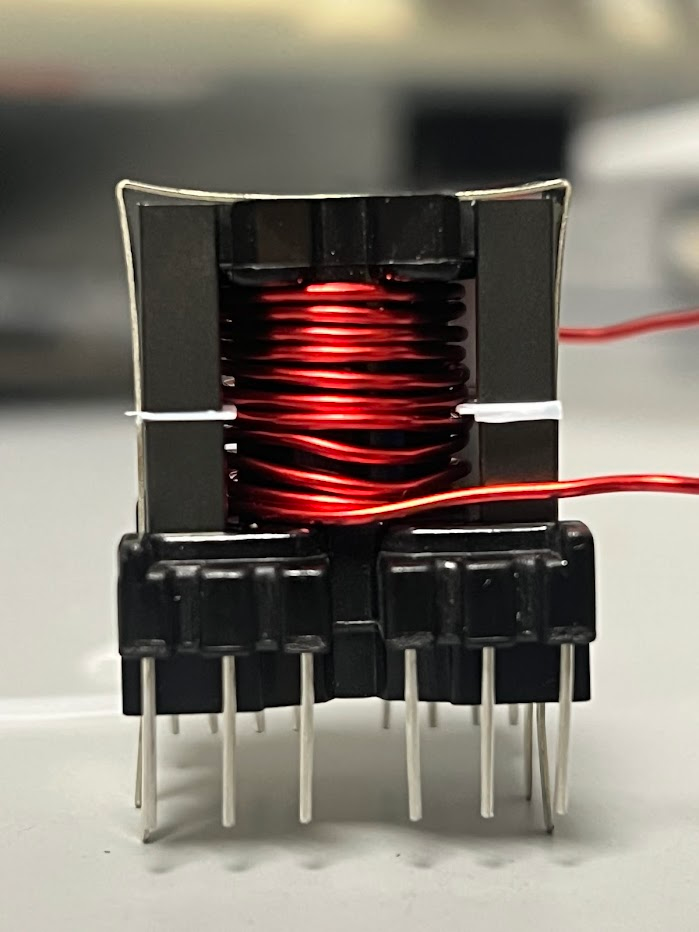
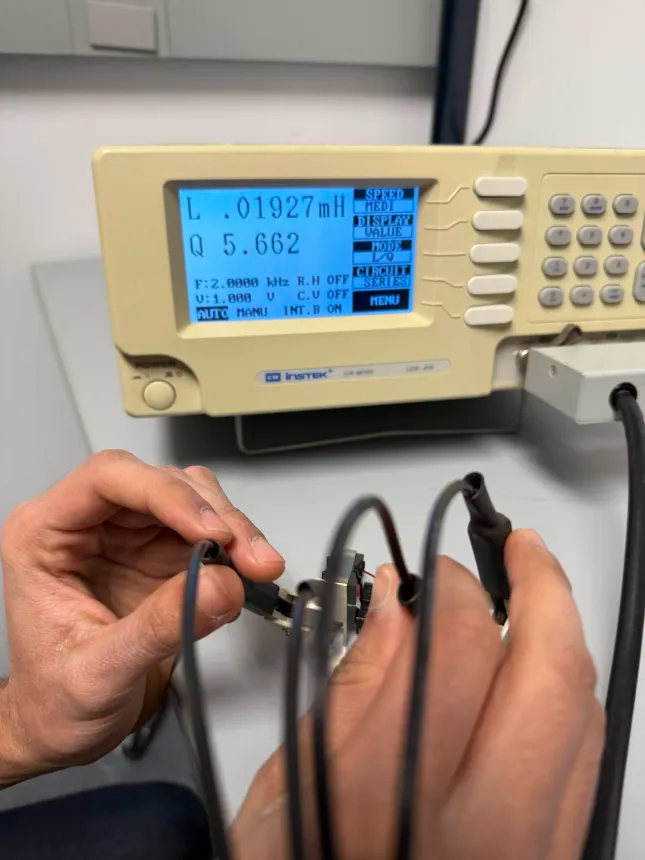

### Energy Storage

Using the equation 

$$
W = \frac{1}{2} \phi^2 R_e
$$

for both the core and the air gap reluctance, I found the peak energy storage in the inductor to be about 0.48 millijoules, calculated in the below code cell

In [27]:
Wair = 0.5 * max_flux**2 * Rg
Wcore = 0.5 * max_flux**2 * 1/3300 # from material properties of core
print(f"Core energy storage: {Wair} J, Air gap energy storage: {Wcore} J, total: {Wair + Wcore} J")

Core energy storage: 0.0004811908125324107 J, Air gap energy storage: 2.3750060606060615e-14 J, total: 0.00048119081255616075 J


# Lab

### Q1
The plots are generated by the code cell below.

### Q2
The current shown by our power supply was **200mA**

### Q3
The below code cell calculates our inductance to be 18.76 uH. This calculation was performed using the equation 

$$L = \frac{V}{\frac{dI}{dt}}$$

where $\frac{dI}{dt}$ was calculated by taking the slope of the shunt current ($\frac{V_{shunt}}{R_{shunt}}$) in the timespan `t` where the inductor is charging and the FET is closed, and $V$ is approximated as the difference between the input and the output voltage (treating the FET drain and shunt as negligible)

Inductance at shunt voltage of 100mV: 18.289 uH


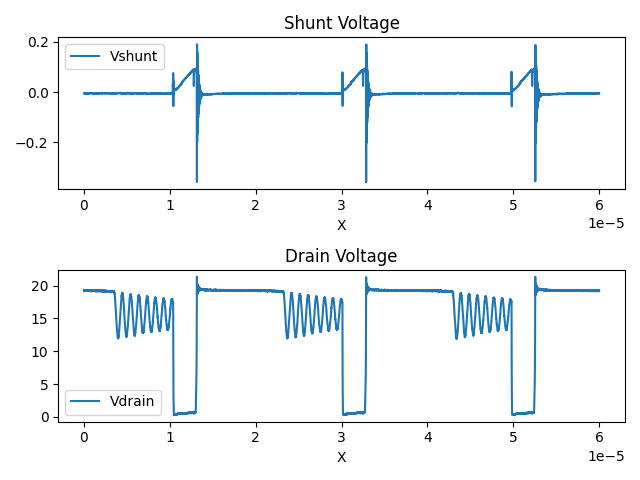

In [28]:
V = 3.55
t = (3.05e-5, 3.25e-5)
Ls = []

figure, (ax1, ax2) = plt.subplots(2,1)
mv100, _ = import_and_clean('100mV', ["Vshunt", "Vdrain"], True)
mv100['Vdrain'] -= 7.7 # scope offset
mv100.plot(x="X", y="Vshunt", ax=ax1, title="Shunt Voltage")
mv100.plot(x="X", y="Vdrain", ax=ax2, title="Drain Voltage")
Ls.append(L := calc_inductance(mv100, *t, V))
figure.tight_layout()
print(f"Inductance at shunt voltage of 100mV: {round(L * 10e5, 3)} uH")


### Q4
The plots are generated by the code cell below.

### Q5
The current shown by our power supply was **830mA**

### Q6
The below code cell calculates our inductance to be 19.103 uH using the same method as above, so between the 100mV and 200mV shunt voltatge experiments, the mean calculated inductance is 18.931.

Inductance at shunt voltage of 200mV: 19.107 uH
Mean Inductance: 18.698 uH


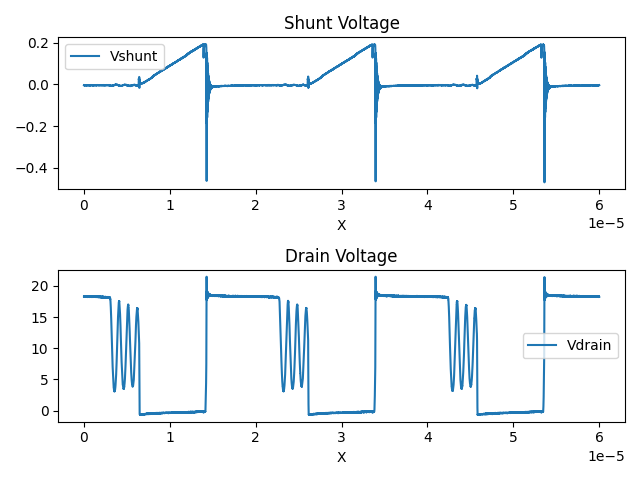

In [29]:
V = 8.13
t = (2.8e-5, 3.2e-5)

figure, (ax1, ax2) = plt.subplots(2,1)
mv200, _ = import_and_clean('200mV', ["Vshunt", "Vdrain"], True)
mv200['Vdrain'] -= 7.7 # scope offset
mv200.plot(x="X", y="Vshunt", ax=ax1, title="Shunt Voltage")
mv200.plot(x="X", y="Vdrain", ax=ax2, title="Drain Voltage")
Ls.append(L := calc_inductance(mv200, *t, V))
figure.tight_layout()
print(f"Inductance at shunt voltage of 200mV: {round(L * 10e5, 3)} uH")


print(f"Mean Inductance: {round(np.mean(Ls) * 10e5, 3)} uH")

### Q 7-8

After measuring the converter performance in this lab, measuring with the LCR, and performing our theoretical calcualtions, we are quite confident that this inductor falls into the inductance specifications given by the prelab. That said, one initial stumbling block we had was not correctly calculating the equivalent cross-sectional area of the air gap. At various points we had tried the Wheeler approximation for an air-core inductor, as well as simply using the ferrite core's cross-sectional area, before we finally landed on approximating with an air-gap-length band around the core diameter (the method that gave us our final result)

### Q9

See attached screengrab of drawing.

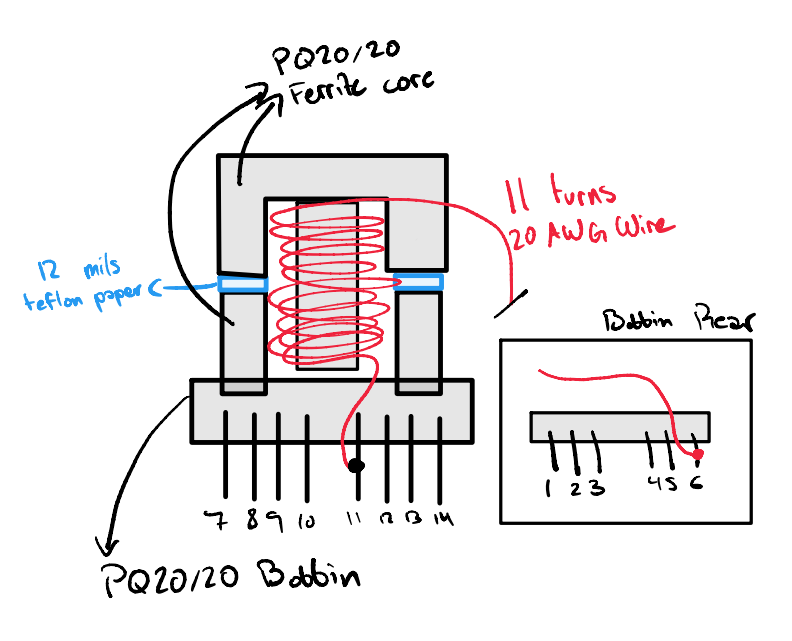

### Q10

**100mV shunt**

This graph was generated by setting the output voltage in my digital twin to the 3.55V we measured in our real circuit.

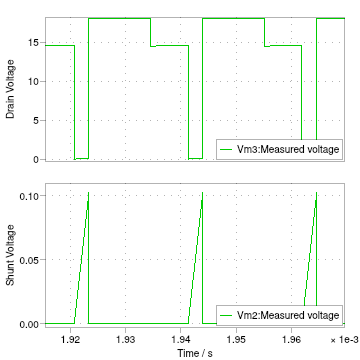

Overall, the waveforms exhibit similar characteristics, with similar inconsistencies between real and simulation from the previous lab. Both shunt voltages are near the 100mV target, with the real circuit showing some voltage spikes when the FET switches, likely due to EMI from rapidly changing current. The drain graph shows three distinct modes of operation in both the real and simulated plots; near 0V when the FET is on, near the supply voltage of 18V when the FET turns off, and the difference between the supply and the output when the FET is off and the inductor is fully discharged. Similarly to the previous lab, there is a sinusoidal ringing in that third state, perhaps due to various parasitic capacitances/leakage inductances in our real circuit, however the sinusoid appears to be centered around the same point as in the simulation. The duty cycle for the real circuit is 12.99% (calculated in the below code cell), which matches the simulated duty cycle almost exactly at  13.00%.

In [30]:
print(f"{round(float(duty_cycle(mv100, "Vdrain", 2.9e-5, 3.3e-5, thresh=1)) * 100, 3)}%")

12.999%


**200mV shunt**

This graph was generated by setting the output voltage in my digital twin to the 8.13V we measured in our real circuit.

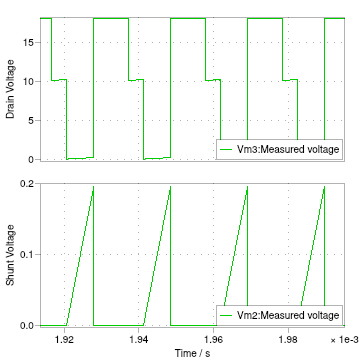

Overall, the waveforms exhibit similar characteristics, with similar inconsistencies between real and simulation from the previous lab. Both shunt voltages are near the 200mV target, with the real circuit again showing similar voltage spikes when the FET switches. The drain graph still shows three distinct modes of operation in both the real and simulated plots, with the main difference being that the voltage level when the FET is off and the inductor is fully discharged has changed to about 10V to reflect the new output voltage. The 200mV version retains the same sinusoidal ringing as in the 100mV version. The duty cycle for the real circuit is 38.9% (calculated in the below code cell), which doesn't match the simulated duty cycle of 35.03% as well as the 100mV version (the output voltage in the sim is also 7.86V vs 8.13V, which is a higher error than the 90mV or so of the 100mV version), likely due to some combination of measurement error in our circuit.

In [31]:
print(f"{round(float(duty_cycle(mv200, "Vdrain", 2.4e-5, 3.6e-5, thresh=1)) * 100, 2)}%")

38.86%


### Q11

See the below code cell for the lambda vs current plot generation

Slope at 100mV: 1.7441306322885038e-05
Slope at 200mV: 2.77472655292814e-05


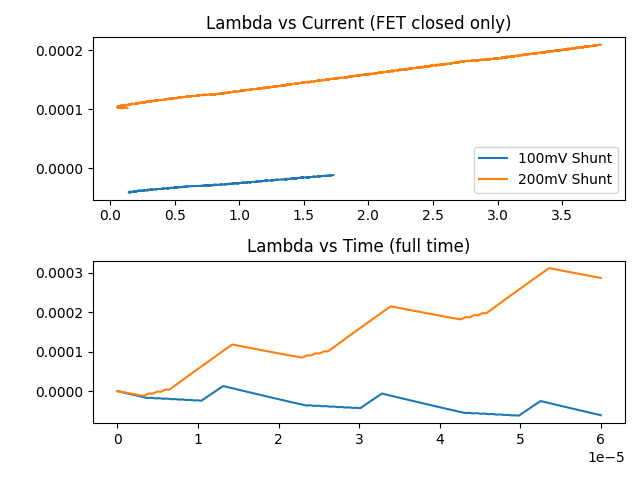

In [32]:
plt.cla()
figure, (ax, ax2) = plt.subplots(2,1)
for df, title, time in zip([mv100, mv200], ['100mV', '200mV'], [(3.03e-5, 3.24e-5), (2.62e-5, 3.35e-5)]):
    rng = np.where((df["X"] > time[0]) & (df["X"] < time[1]))[0]

    df["I"] = df["Vshunt"] / R_SHUNT # calculate current
    df["V_L"] = (VG - 3.55 - df["Vdrain"] - df["Vshunt"]).fillna(0) # Inductor Voltage
    Lambda = np.concatenate(([0], cumulative_trapezoid(df["V_L"], df["X"]))) # integrate w respect time


    ax.plot(df["I"][rng[0]:rng[-1]], Lambda[rng[0]:rng[-1]])
    ax2.plot(df["X"], Lambda)
    ax.set_title(f"Lambda vs Current (FET closed only)")
    ax2.set_title("Lambda vs Time (full time)")

    dLambda = np.polyfit(df["I"][rng[0]:rng[-1]], Lambda[rng[0]:rng[-1]], 1)[0]
    print(f"Slope at {title}: {dLambda}")

figure.tight_layout()
ax.legend(['100mV Shunt', '200mV Shunt'])
